In [1]:
## This script evaluates the correlations between models and all experimental datasets for plotting figures
# Requires that sentence pairwise similarities have already been computed using 'Cals_sent_sim_[type].ipynb' files.
# Run using base python 3.9
# James Fodor 2023

# load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sentence_embeds_processing as sep
import os
import re

from scipy.stats import spearmanr

# base path for all data files
path_root = "D:\Study and Projects\School Work\Year 25 - PhD\Data\\"
data_pairs_path = path_root+'\\Sentence Similarity Data\\Sentence Similarities Final\\'
data_nonpaired_path = path_root+'\\Neuroimaging Data\\'
sims_path = 'Analysis Results\Sentence Similarities\\'
parses_path = 'Analysis Results\Sentence Parses\\'

# set display options
np.set_printoptions(precision=4, threshold=5000, linewidth=220, suppress=True, floatmode='fixed')
pd.set_option('display.float_format', '{:.3f}'.format)
sns.set()

### Load sentence similarity datasets

In [2]:
# Show available datasets
pairs = True # specify if we are using paired data or list of sentences
if pairs==True:
    datasets = sep.available_pair_datasets
else:
    datasets = sep.available_nonpaired_datasets
print(datasets)

{0: 'GS2011_processed', 1: 'KS2013_processed', 2: 'Fodor_pilot_2022', 3: 'STS131_processed', 4: 'SICK_relatedness', 5: 'STSb_captions_test', 6: 'STSb_forums_test', 7: 'STSb_headlines_test', 8: 'STSb_test', 9: 'STS3k_all'}


In [3]:
## Load STS3k indices sets
adv_noneg_indices = np.loadtxt('STS3k_adv_noneg_indices.txt', delimiter=',', dtype='int', encoding='utf-8', skiprows=0)
non_adv_indices = np.loadtxt('STS3k_non_adv_indices.txt', delimiter=',', dtype='int', encoding='utf-8', skiprows=0)

In [26]:
## Load all combinations of datasets and models
sim_storage = {}
for dataset_name in datasets.values():

    # Load sentence set
    sentences_dict = sep.load_set_of_sentences(dataset_name, data_pairs_path, data_nonpaired_path, True)
    print('loaded',dataset_name)

    # get experimental similarities for sentence pairs    
    sim_storage[dataset_name] = {}
    sim_storage[dataset_name]['expr'] = np.array(list(sentences_dict.values()))[:,2].astype(float)

    # loop over all model functions to load data
    all_files = os.listdir(path_root+sims_path)
    count = 0
    for file_name in all_files:
        
        # Regular expression pattern to match files for given model
        filename_pattern = r"^{}.*\.txt$".format(dataset_name)

        # Check if the filename matches the desired filename_pattern
        if re.match(filename_pattern, file_name):
            basename_pattern = r"{}_(.*?)_similarities.txt".format(dataset_name) # extract basename to save
            base_name = sep.extract_text_between(basename_pattern, file_name)[0]
            sim_storage[dataset_name][base_name] = arr_no_nan = np.nan_to_num(sep.load_sentence_sim_values(path_root+sims_path+file_name))
            count+=1
            
    print(count,'files loaded')

loaded GS2011_processed
33 files loaded
loaded KS2013_processed
31 files loaded
loaded Fodor_pilot_2022
20 files loaded
loaded STS131_processed
31 files loaded
loaded SICK_relatedness
31 files loaded
loaded STSb_captions_test
34 files loaded
loaded STSb_forums_test
31 files loaded
loaded STSb_headlines_test
3 files loaded
loaded STSb_test
30 files loaded
loaded STS3k_all
46 files loaded


### Compute correlations between sentence similarities across datasets

In [31]:
## Compute correlations for selected datasets

datasets_to_plot = ['STSb_captions_test', 'STSb_forums_test', 'STSb_test', 'SICK_relatedness', 'STS131_processed', 'STS3k_all', 'STS3k_nonadv', 'STS3k_adv']
models_to_plot = ['mean', 'mult', 'conv', 'infersent', 'universal_norml', 'ernie_0_norml', 'ernie_12_norml', 'dictBERT_norml', 
                  'sentbert_mpnet_norml', 'openai_norml', 'defsent_cls_norml',  'smatch', 'WLK_Wasser', 'S3BERT_norml',
                  'AMR', 'verbnet_fixedparms_basic', 'verbnet_fixedparms_norm']
datasets_shortnames = ['STSb-c', 'STSb-f', 'STSb', 'SICK', 'STS131', 'STS3k-all', 'STS3k-non', 'STS3k-adv']
models_shortnames = ['mean', 'mult', 'conv', 'InferSent', 'USE', 'ERNIE-0', 'ERNIE-12', 'dictBERT', 'SentBERT', 'OpenAI',
                     'DefSent', 'Smatch', 'WWLK', 'S3BERT', 'AMR-CN', 'VerbNet-CN-basic', 'VerbNet-CN-norm']
corr_storage = np.zeros((len(models_to_plot), len(datasets_to_plot)))
i = 0
j = 0

for dataset_name in datasets_to_plot:
    j=0
    for model in models_to_plot:
        try:
            if dataset_name=='STS3k_adv': # special case
                model_sims = sim_storage['STS3k_all'][model][adv_noneg_indices]
                expr_sims = sim_storage['STS3k_all']['expr'][adv_noneg_indices]
            elif dataset_name=='STS3k_nonadv': # special case
                model_sims = sim_storage['STS3k_all'][model][non_adv_indices]
                expr_sims = sim_storage['STS3k_all']['expr'][non_adv_indices]
            else: # all other cases
                model_sims = sim_storage[dataset_name][model]
                expr_sims = sim_storage[dataset_name]['expr']
            corr,_ = spearmanr(model_sims,expr_sims)
        except:
            corr = np.NaN
        corr_storage[j,i] = corr
        j+=1
    i+=1

In [32]:
## Print table of key correlations
df = pd.DataFrame(corr_storage, columns = datasets_shortnames, index = models_shortnames)
df

,STSb-c,STSb-f,STSb,SICK,STS131,STS3k-all,STS3k-non,STS3k-adv
mean,0.806,0.519,0.689,0.597,0.871,0.368,0.800,-0.291
mult,0.259,0.278,0.168,0.273,0.273,0.096,0.450,-0.333
conv,0.164,0.271,0.158,0.268,0.078,-0.042,0.323,-0.462
InferSent,0.798,0.428,0.661,0.663,0.868,0.445,0.830,-0.088
USE,0.881,0.714,0.795,0.702,0.900,0.442,0.824,-0.071
ERNIE-0,NaN,0.543,0.597,0.615,0.749,0.423,0.799,-0.107
ERNIE-12,0.604,0.715,0.549,0.597,0.809,0.576,0.834,0.227
dictBERT,0.678,0.601,0.563,0.627,0.843,0.516,0.826,0.105
SentBERT,0.929,0.719,0.836,0.803,0.939,0.580,0.866,0.145
OpenAI,0.923,0.829,0.835,0.804,0.960,0.598,0.890,0.184


### Plot graphs of model correlations

In [34]:
corr_storage[:,2:]

array([[ 0.6893,  0.5969,  0.8706,  0.3682,  0.7999, -0.2909],
       [ 0.1685,  0.2733,  0.2735,  0.0955,  0.4497, -0.3332],
       [ 0.1582,  0.2677,  0.0777, -0.0418,  0.3225, -0.4619],
       [ 0.6614,  0.6627,  0.8681,  0.4448,  0.8299, -0.0878],
       [ 0.7954,  0.7016,  0.9001,  0.4424,  0.8241, -0.0714],
       [ 0.5974,  0.6148,  0.7489,  0.4229,  0.7989, -0.1067],
       [ 0.5489,  0.5967,  0.8092,  0.5759,  0.8338,  0.2272],
       [ 0.5626,  0.6273,  0.8432,  0.5159,  0.8263,  0.1047],
       [ 0.8358,  0.8035,  0.9394,  0.5799,  0.8661,  0.1448],
       [ 0.8353,  0.8045,  0.9599,  0.5983,  0.8898,  0.1841],
       [ 0.8120,  0.7845,  0.9423,  0.7009,  0.8618,  0.4939],
       [    nan,  0.5020,  0.6525,  0.4238,  0.6658,  0.0289],
       [    nan,  0.6332,  0.8292,  0.3163,  0.7099, -0.2704],
       [ 0.8414,  0.8108,  0.9399,  0.5708,  0.8655,  0.1221],
       [    nan,  0.5171,  0.4337,  0.6017,  0.6314,  0.6082],
       [    nan,     nan,     nan,  0.6725,  0.6520,  0

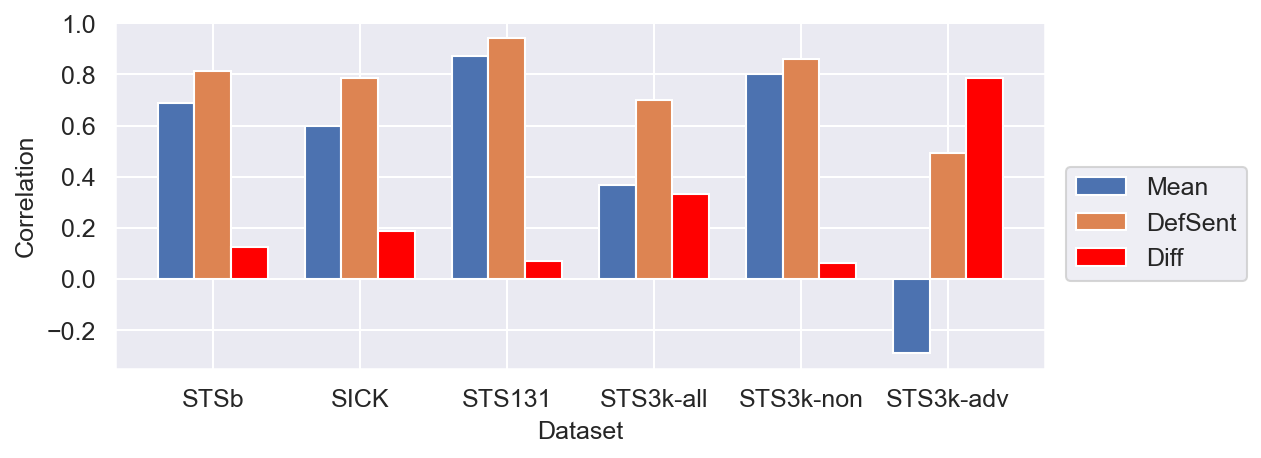

In [35]:
## Plot bar graphs with correlations and differences

# Correlation set to analyse
corr_analyse = corr_storage[:,2:]
names_analyse = datasets_shortnames[2:]

# Plot parameters
x_axis = np.arange(len(corr_analyse[0]))
offsets = 1/2
bar_width = 0.25
font_size = 12

# Generate bar plot
fig, ax = plt.subplots(figsize=(8,3), dpi=150)
plt.bar(x=x_axis-offsets*2*bar_width, height=corr_analyse[0], width=bar_width, label='Mean')
plt.bar(x=x_axis, height=corr_analyse[10], width=bar_width, label='DefSent')
plt.bar(x=x_axis+offsets*2*bar_width, height=corr_analyse[10]-corr_analyse[0], width=bar_width, label='Diff', color='red')
plt.xticks(x_axis, names_analyse, fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.legend(fontsize=font_size, bbox_to_anchor=(1.23, 0.62), loc='upper right')
plt.ylabel('Correlation', fontsize=font_size)
plt.xlabel('Dataset', fontsize=font_size)
plt.show()

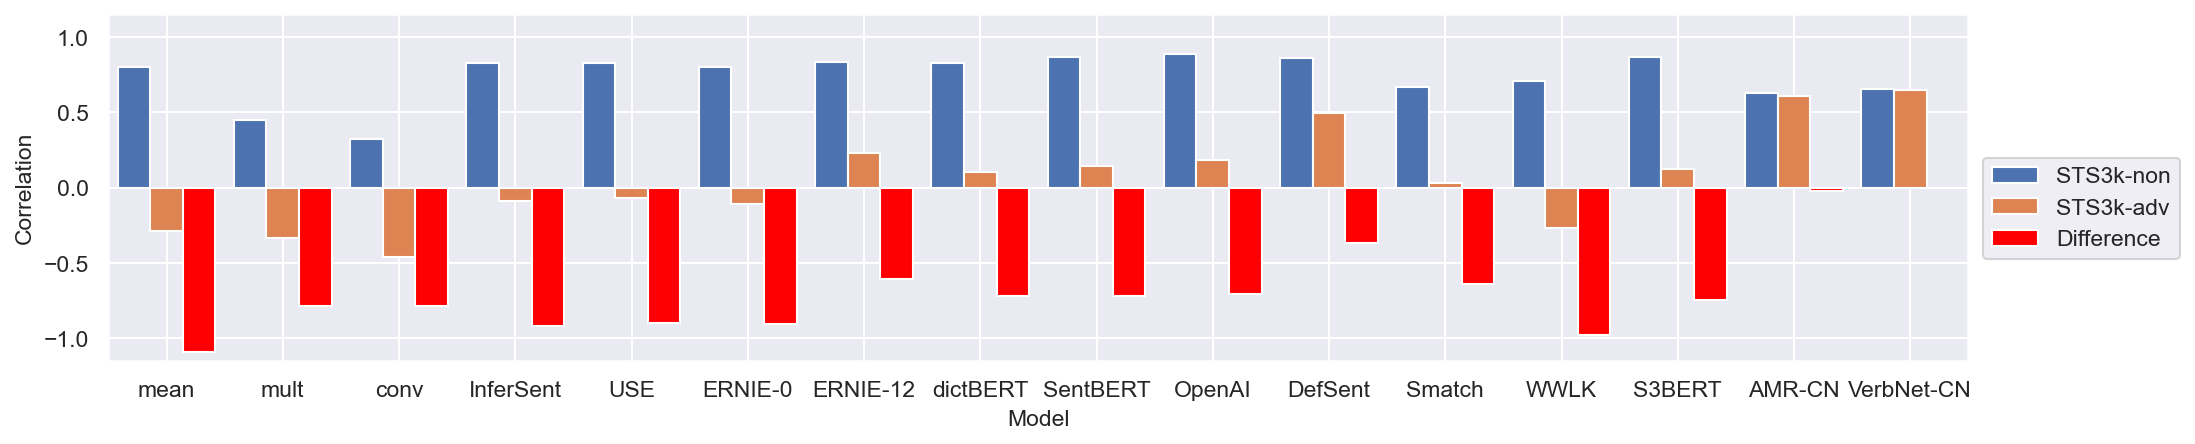

In [57]:
## Plot bar graphs with correlations and differences

# Correlation set to analyse
corr_analyse = corr_storage

# Plot parameters
x_axis = np.arange(len(corr_analyse[:,0]))
offsets = 1/2
bar_width = 0.28
font_size = 11

# Generate bar plot
fig, ax = plt.subplots(figsize=(16,3), dpi=150)
plt.bar(x=x_axis-offsets*2*bar_width, height=corr_analyse[:,5], width=bar_width, label='STS3k-non')
plt.bar(x=x_axis, height=corr_analyse[:,6], width=bar_width, label='STS3k-adv')
plt.bar(x=x_axis+offsets*2*bar_width, height=corr_analyse[:,6]-corr_analyse[:,5], width=bar_width, label='Difference', color='red')
plt.xticks(x_axis, models_shortnames, fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.legend(fontsize=font_size, bbox_to_anchor=(1.12, 0.62), loc='upper right')
plt.ylabel('Correlation', fontsize=font_size)
plt.xlabel('Model', fontsize=font_size)
plt.xlim(xmax = 15.5, xmin = -0.5)
plt.ylim(ymax = 1.15, ymin = -1.15)
plt.show()